Initialise neuron and build a simple cell.

In [1]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

h.load_file('stdrun.hoc')

# build soma (starter parameters)
soma = h.Section(name='soma')
soma.L = soma.diam = 20  # µm
soma.Ra = 100            # ohm·cm
soma.cm = 1              # µF/cm2

# passive + Hodgkin-Huxley channels
soma.insert('pas')
soma.e_pas = -65
soma.g_pas = 1e-4
soma.insert('hh')

soma

In [2]:
v_hold=-80.0   # mV: holding voltage before and after the step
v_step=20.0    # mV: step voltage
pre=5.0        # ms: duration before the step
step=5.0       # ms: step duration
post=5.0       # ms: duration after the step
loc=0.5
dt=0.025 

# create SEClamp at specified location
clamp = h.SEClamp(soma(loc))
clamp.dur1 = pre
clamp.amp1 = v_hold
clamp.dur2 = step
clamp.amp2 = v_step
clamp.dur3 = post
clamp.amp3 = v_hold

# record time, clamp current, and membrane voltage
tvec = h.Vector(); tvec.record(h._ref_t)
ivec = h.Vector(); ivec.record(clamp._ref_i)        # clamp current (nA)
vvec = h.Vector(); vvec.record(soma(loc)._ref_v)    # membrane voltage (mV)

# simulation control
h.dt = dt
total = pre + step + post
h.tstop = total
h.finitialize(v_hold)   # initialize at holding potential (helps avoid large transients)
h.run()

0.0

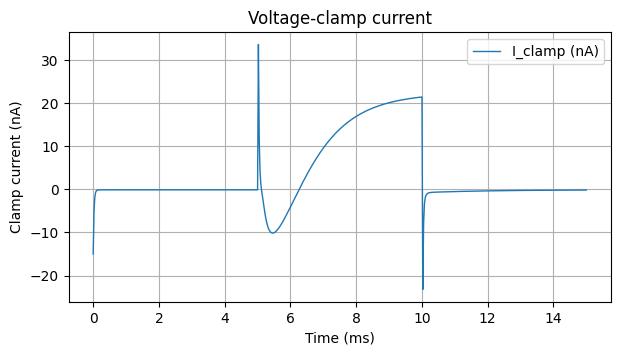

In [3]:
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot(tvec, ivec, color='tab:blue', lw=1, label='I_clamp (nA)')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Clamp current (nA)')
ax.set_title("Voltage-clamp current")
ax.legend(loc='upper right')
ax.grid(True)


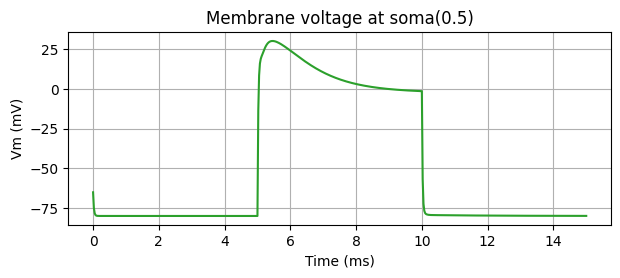

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(7, 2.5))
ax.plot(tvec, vvec, color='tab:green')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
ax.set_title('Membrane voltage at soma(0.5)')
ax.grid(True)

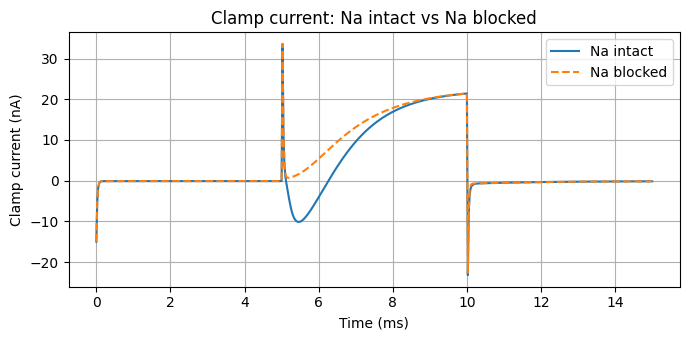

In [12]:
# save original gNa, set up recorders for two runs
orig_gna = getattr(soma, 'gnabar_hh')  # typical name for hh Na bar
# run 1: Na intact
t = h.Vector(); i = h.Vector()
t.record(h._ref_t)
i.record(clamp._ref_i)

soma.gnabar_hh = orig_gna
h.finitialize(v_hold)
h.run()

# convert to numpy for plotting/comparison
t1_np = np.array(t)
i1_np = np.array(i)

# run 2: Na blocked
soma.gnabar_hh = 0.0
h.finitialize(v_hold) #Running `h.finitialize(v_hold)` before each run ensures comparable initial conditions; we restore gNa after the comparison.
h.run()

# restore original gNa
soma.gnabar_hh = orig_gna

# convert to numpy for plotting/comparison
t2_np = np.array(t)
i2_np = np.array(i)

# simple comparison plot
plt.figure(figsize=(7, 3.5))
plt.plot(t1_np, i1_np, label='Na intact', color='tab:blue')
plt.plot(t2_np, i2_np, label='Na blocked', color='tab:orange', linestyle='--')
plt.xlabel('Time (ms)')
plt.ylabel('Clamp current (nA)')
plt.title('Clamp current: Na intact vs Na blocked')
plt.legend()
plt.grid(True)
plt.tight_layout()

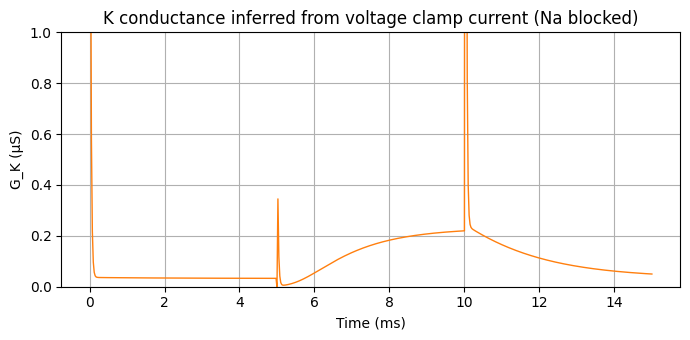

In [19]:
# --- compute K conductance from the measured clamp current (Na blocked run)

# membrane area
area_um2 = soma(0.5).area()            # µm^2
area_cm2 = area_um2 * 1e-8             # cm^2

# construct the commanded clamp waveform (mV) matching t2_np
t = t2_np
V_cmd = np.where(t < pre, v_hold,
                 np.where(t < (pre + step), v_step, v_hold))

# retrieve EK if available, else fall back to typical hh default
ek = getattr(soma, 'ek_hh', getattr(soma, 'ek', -77.0))

# compute leak current (nA) from area and g_pas (g_pas is S/cm^2)
G_leak_S = soma.g_pas * area_cm2              # S
I_leak_A = G_leak_S * (V_cmd - soma.e_pas) * 1e-3  # V from mV -> A = S * V
I_leak_nA = I_leak_A * 1e9

# ionic K current estimate (nA) = measured clamp current (nA) - leak (nA)
I_K_nA = i2_np - I_leak_nA

# inferred macroscopic K conductance in µS (nA / mV = µS)
# avoid division by zero
dv = (V_cmd - ek)
dv_small = np.isclose(dv, 0.0)
gK_from_clamp_uS = np.zeros_like(dv)
gK_from_clamp_uS[~dv_small] = I_K_nA[~dv_small] / dv[~dv_small]

# simple plot of inferred G_K
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3.5))
plt.plot(t, gK_from_clamp_uS, color='C1', lw=1)
plt.ylim([0, 1])
plt.xlabel('Time (ms)')
plt.ylabel('G_K (µS)')
plt.title('K conductance inferred from voltage clamp current (Na blocked)')
plt.grid(True)
plt.tight_layout()

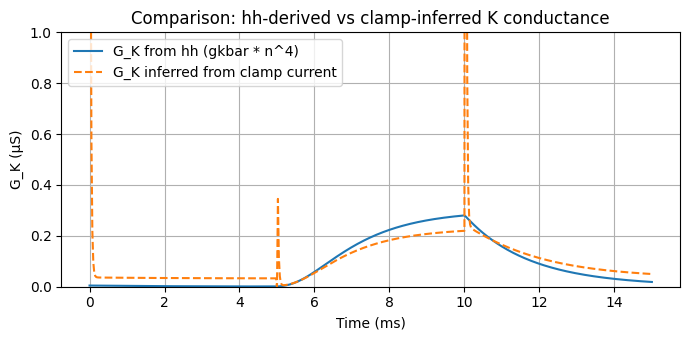

In [21]:
# --- run a short simulation to extract hh gating n and compute hh-derived G_K(t)
# record n from the hh mechanism; block Na so K dominates (reuse the existing clamp)
t_rec = h.Vector(); t_rec.record(h._ref_t)
# record hh gating variable n (mechanism reference)
n_rec = h.Vector(); n_rec.record(soma(0.5).hh._ref_n)
# ensure Na is blocked for this measurement
orig_gna = getattr(soma, 'gnabar_hh', None)
if orig_gna is None:
    raise RuntimeError("Expected soma.gnabar_hh to exist (hh mechanism).")
soma.gnabar_hh = 0.0
# run
h.finitialize(v_hold)
h.run()
# restore
soma.gnabar_hh = orig_gna

t_n = np.array(t_rec)
n_np = np.array(n_rec)

# macroscopic G_K from hh parameters:
gkbar = getattr(soma, 'gkbar_hh', None)
if gkbar is None:
    raise RuntimeError("Expected soma.gkbar_hh to exist (hh mechanism).")
Gk_hh_S = gkbar * (n_np**4) * area_cm2   # S
Gk_hh_uS = Gk_hh_S * 1e6                 # µS

# plot hh-derived conductance and overlay the clamp-derived estimate (interpolated to same t)
import numpy as np
gK_interp = np.interp(t_n, t, gK_from_clamp_uS)  # map clamp estimate onto t_n grid

plt.figure(figsize=(7,3.5))
plt.plot(t_n, Gk_hh_uS, label='G_K from hh (gkbar * n^4)', color='C0')
plt.plot(t_n, gK_interp, label='G_K inferred from clamp current', color='C1', linestyle='--')
plt.ylim([0, 1])
plt.xlabel('Time (ms)')
plt.ylabel('G_K (µS)')
plt.title('Comparison: hh-derived vs clamp-inferred K conductance')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

In [11]:
def run_voltage_step(soma,
                     v_hold=-80.0,   # mV: holding voltage before and after the step
                     v_step=20.0,    # mV: step voltage
                     pre=5.0,        # ms: duration before the step
                     step=50.0,      # ms: step duration
                     post=45.0,      # ms: duration after the step
                     loc=0.5,
                     dt=0.025):
    """
    Run a 3-segment SEClamp: (pre v_hold), (step v_step), (post v_hold).
    Returns:
      t (np.array) : time (ms)
      i (np.array) : clamp current (nA) recorded from SEClamp._ref_i
      vm (np.array): membrane voltage (mV) at soma(loc)
      timings (dict): {'pre':pre, 'step':step, 'post':post}
    """
    # create SEClamp at specified location
    clamp = h.SEClamp(soma(loc))
    clamp.dur1 = pre
    clamp.amp1 = v_hold
    clamp.dur2 = step
    clamp.amp2 = v_step
    clamp.dur3 = post
    clamp.amp3 = v_hold

    # record time, clamp current, and membrane voltage
    tvec = h.Vector(); tvec.record(h._ref_t)
    ivec = h.Vector(); ivec.record(clamp._ref_i)        # clamp current (nA)
    vvec = h.Vector(); vvec.record(soma(loc)._ref_v)    # membrane voltage (mV)

    # simulation control
    h.dt = dt
    total = pre + step + post
    h.tstop = total
    h.finitialize(v_hold)   # initialize at holding potential (helps avoid large transients)
    h.run()

    return np.array(tvec), np.array(ivec), np.array(vvec), {'pre': pre, 'step': step, 'post': post}

In [12]:
def plot_clamp_current(t, i, timings=None, title='SEClamp current response', ax=None,
                       smooth=None, xlim=None, auto_zoom=False, xpad=5.0):
    """
    Plot clamp current vs time with options to control x-axis.

    Parameters
    - t: time array (ms)
    - i: clamp current (nA)
    - timings: optional dict with keys 'pre', 'step', 'post' (ms)
    - smooth: optional tuple (window_length, polyorder) to apply Savitzky-Golay smoothing (requires scipy)
    - xlim: optional (xmin, xmax) tuple (ms). If provided, this overrides auto_zoom.
    - auto_zoom: if True and timings provided, set x-axis to [pre - xpad, pre + step + xpad]
    - xpad: padding (ms) when auto_zoom is used (applied on both sides)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 3.5))
    ax.plot(t, i, color='tab:blue', lw=1, label='I_clamp (nA)')

    if smooth is not None:
        try:
            from scipy.signal import savgol_filter
            window_len, polyorder = smooth
            sm = savgol_filter(i, window_len, polyorder)
            ax.plot(t, sm, color='tab:orange', lw=1, label='smoothed')
        except Exception:
            ax.text(0.02, 0.95, 'savgol filter not applied', transform=ax.transAxes, va='top', fontsize=8)

    if timings is not None:
        pre = timings['pre']
        step = timings['step']
        ax.axvline(pre, color='0.5', linestyle='--', label='step onset')
        ax.axvline(pre + step, color='0.5', linestyle=':', label='step offset')

    # x-axis control: priority is xlim > auto_zoom > default (full range)
    if xlim is not None:
        ax.set_xlim(xlim)
    elif auto_zoom and (timings is not None):
        start = max(0.0, timings['pre'] - xpad)
        stop = min(float(t[-1]), timings['pre'] + timings['step'] + xpad)
        ax.set_xlim((start, stop))

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Clamp current (nA)')
    ax.set_title(title)
    ax.legend(loc='upper right')
    ax.grid(True)
    return ax

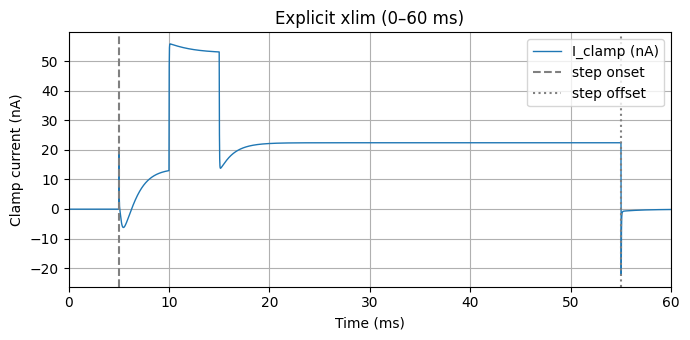

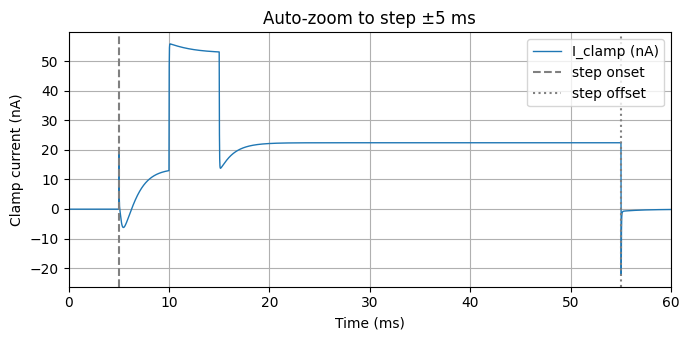

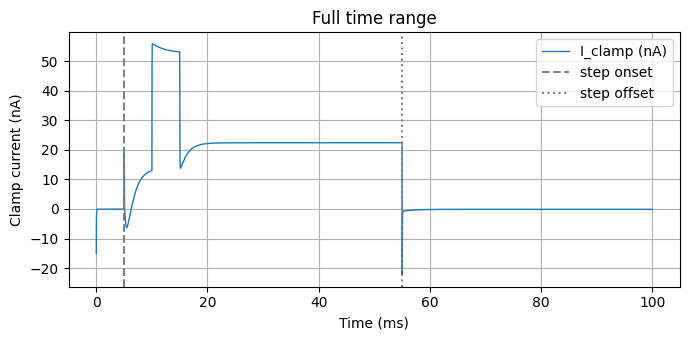

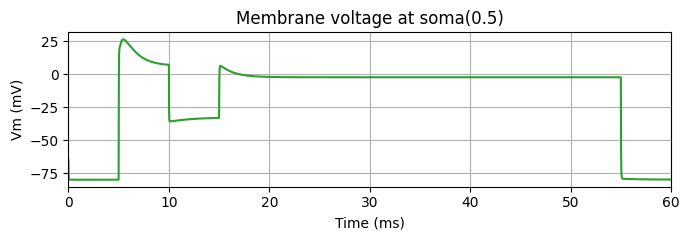

In [13]:
if __name__ == '__main__':
    t, i, vm, timings = run_voltage_step(soma,
                                        v_hold=-80.0,
                                        v_step=20.0,
                                        pre=5.0,
                                        step=50.0,
                                        post=45.0,
                                        loc=0.5,
                                        dt=0.025)

    # 1) explicit x-limits (e.g., show 0-60 ms)
    ax1 = plot_clamp_current(t, i, timings=timings, title='Explicit xlim (0–60 ms)', xlim=(0, 60))
    plt.tight_layout()
    plt.show()

    # 2) auto-zoom to step region with 5 ms padding
    ax2 = plot_clamp_current(t, i, timings=timings, title='Auto-zoom to step ±5 ms', auto_zoom=True, xpad=5.0)
    plt.tight_layout()
    plt.show()

    # 3) default full-range plot
    ax3 = plot_clamp_current(t, i, timings=timings, title='Full time range')
    plt.tight_layout()
    plt.show()

    # optional: also plot Vm for reference (with auto-zoom)
    fig, ax = plt.subplots(1, 1, figsize=(7, 2.5))
    ax.plot(t, vm, color='tab:green')
    if timings is not None:
        if True:  # change to auto_zoom behavior if desired
            start = max(0.0, timings['pre'] - 5.0)
            stop = min(float(t[-1]), timings['pre'] + timings['step'] + 5.0)
            ax.set_xlim((start, stop))
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Vm (mV)')
    ax.set_title('Membrane voltage at soma(0.5)')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    